In [4]:
import os
from openai import OpenAI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn-v0_8")
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
import talib as ta
from talib import MA_Type
import math
pd.set_option('mode.chained_assignment', None)
import plotly.express as px


In [8]:
# Get user input for the stock symbol and start date
stock = input("Choose a stock to view: (EX: MSFT)")
date = input("Choose the date for when you want to start looking at the information in this format - 2015-01-01")

# Create a Ticker object using the yfinance library
ticker = yf.Ticker(stock)

# Retrieve historical stock data from Yahoo Finance starting from the specified date
# Select columns: 'Open', 'Close', 'Volume', 'High', 'Low'
df = ticker.history(start=date)[['Open', 'Close', 'Volume', 'High', 'Low']]

#Create a Date Column
df['Date'] = df.index

#Drop the Date as Index
df.reset_index(drop=True, inplace=True)
df.head()

#Sets padding for figures
def set_padding(fig):
    fig.update_layout(margin=go.layout.Margin(r=10, b=10))

# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['Date'].iloc[0],end=df['Date'].iloc[-1])

# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df['Date'])]

# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]


fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])])

#Sets customized padding
set_padding(fig)

#Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values = dt_breaks)])

fig.update_yaxes(title_text = "Price")
fig.update_xaxes(title_text="Date")

fig.update_layout(title = "{} - Candlestick Chart".format(stock), xaxis_rangeslider_visible=False, height=500, template="plotly_dark")


c:\Users\Pallavi\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



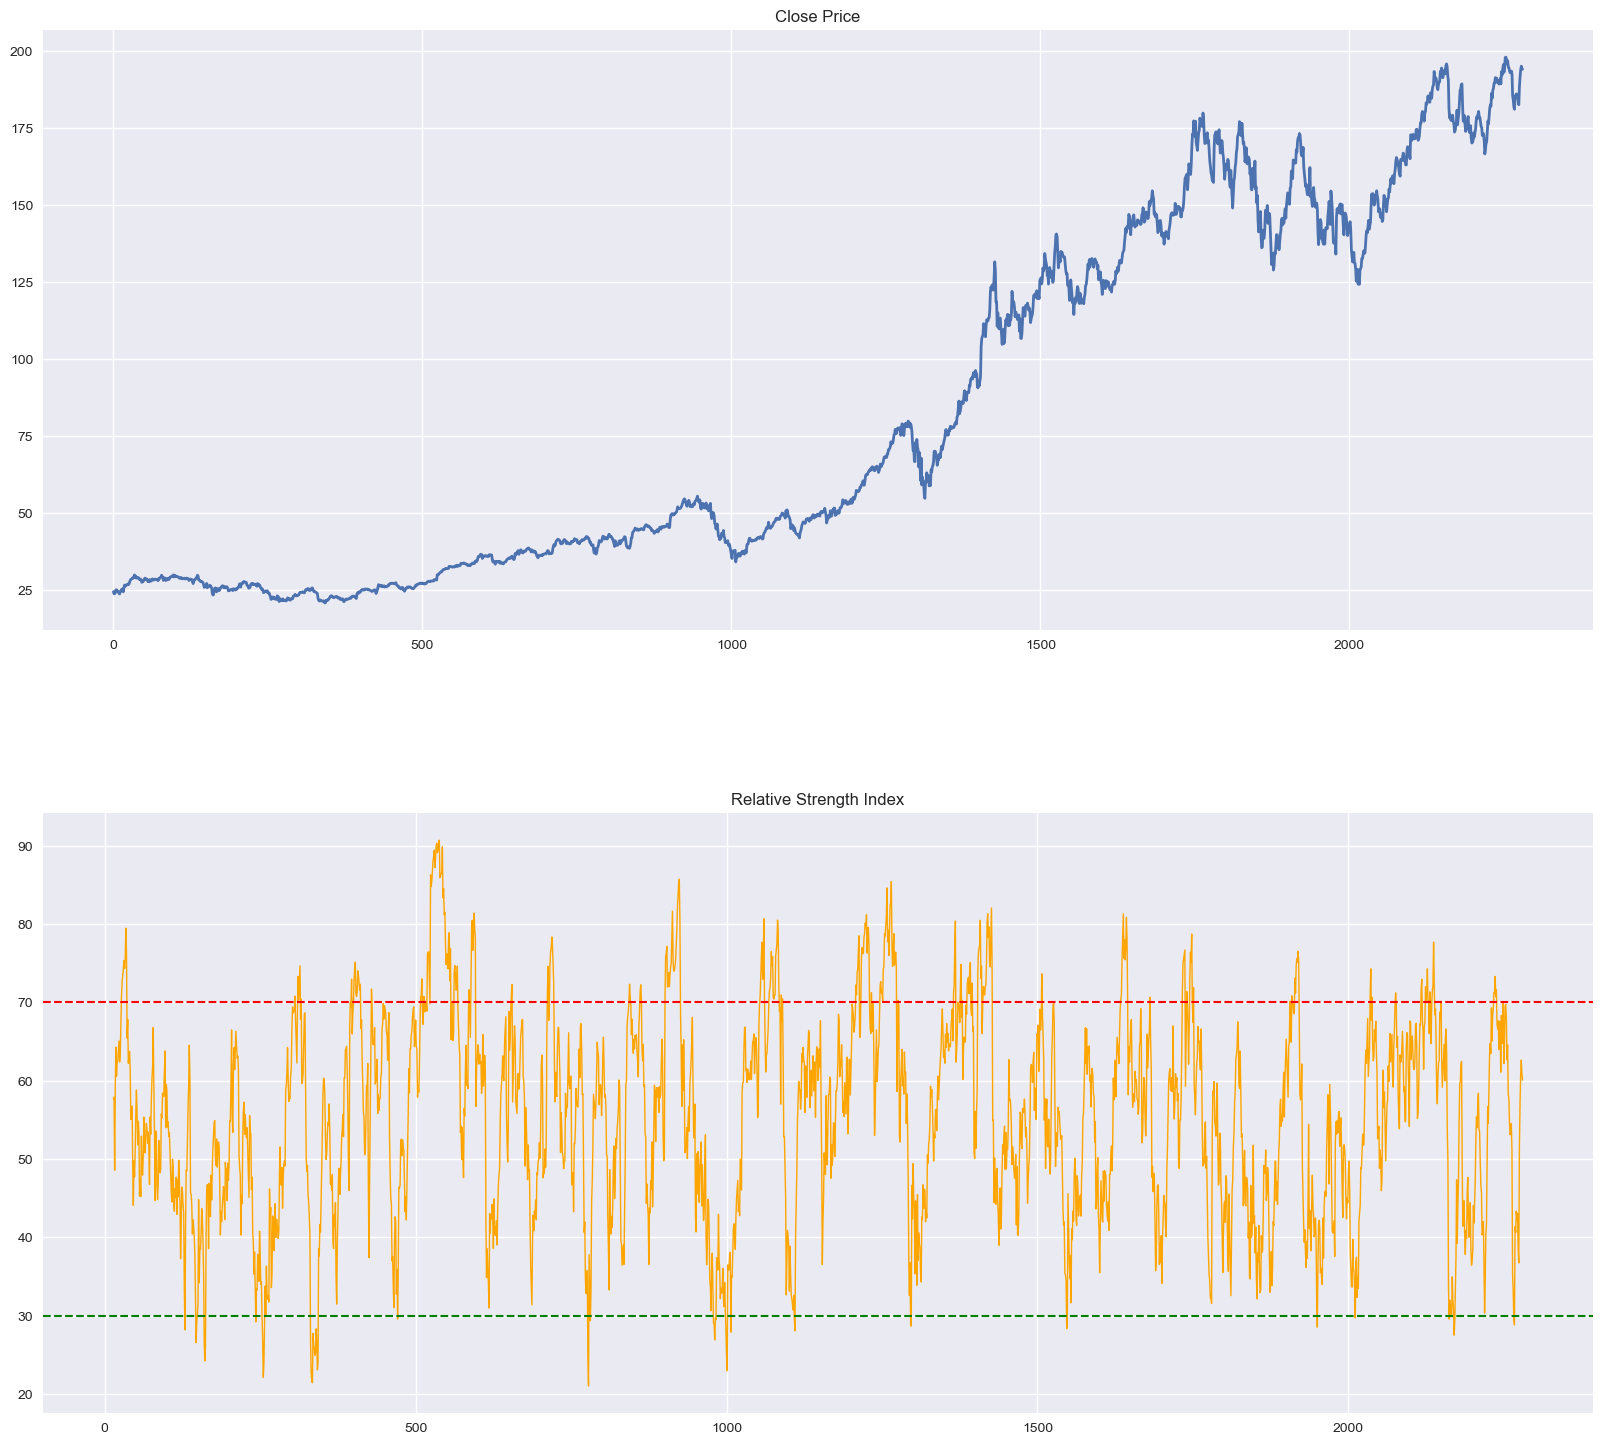

In [10]:
# Calculate Relative Strength Index (RSI) using the 'ta' (technical analysis) library
rsi = ta.RSI(df.Close, 14)

# Set the figure size for the matplotlib plot
plt.rcParams["figure.figsize"] = (20, 20)


# Create two charts on the same figure.
ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan = 4, colspan = 1)


# First chart:
# Plot the closing price on the first chart
ax1.plot(df['Close'], linewidth = 2)
ax1.set_title('Close Price')


# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(rsi, color='orange', linewidth=1)


# Add two horizontal lines, signalling the buy and sell ranges.

# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')

# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

plt.show()

In [13]:
# Adds the range selector to a given figure
def add_range_selector(fig):
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=[
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(count=1, label='YTD', step='year', stepmode='todate'),
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(step='all')
                ]),
            type='date'),
        xaxis2_type='date'
    )

# Adds the volume chart to row 2, column 1
def add_volume_chart(fig):
    # Define colors for volume bars based on price change
    colors = ['#9C1F0B' if row['Open'] - row['Close'] >= 0 else '#2B8308' for index, row in df.iterrows()]

    # Adds the volume as a bar chart
    fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], showlegend=False, marker_color=colors), row=2, col=1)

# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.01, shared_xaxes=True)

# Plot RSI
fig.add_trace(go.Scatter(x=df['Date'], y=df['RSI'], name='RSI'), row=1, col=1)

# Plot Oversold and Overbought lines
fig.add_hline(y=30, line_dash='dash', line_color='limegreen', line_width=1)
fig.add_hline(y=70, line_dash='dash', line_color='red', line_width=1)
fig.update_yaxes(title_text='RSI Score')

# Add the volume chart
add_volume_chart(fig)

# Adds the range selector
add_range_selector(fig)

# Set the color from white to black on range selector buttons
fig.update_layout(xaxis=dict(rangeselector=dict(font=dict(color='black'))))

# Sets customized padding
set_padding(fig)

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

# Update Y & X axis labels
fig['layout']['yaxis']['title'] = 'RSI score'
fig['layout']['yaxis2']['title'] = 'Volume'
fig['layout']['xaxis2']['title'] = 'Date'

# Define a layout for the Plotly figure
layout = go.Layout(
    template='plotly_dark',  # Use the dark template for the plot
    title='{} - RSI'.format(stock),  # Set the title of the plot to 'MSFT - RSI'
    height=500,  # Set the height of the plot to 500 pixels
    legend_title='Legend',  # Set the title for the legend
    xaxis=dict(
        rangeselector=dict(
            font=dict(color='black')  # Set the font color of the rangeselector to black
        )
    )
)

# Update the layout of the Plotly figure
fig.update_layout(layout)


c:\Users\Pallavi\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [16]:
# Calculate Bollinger Bands (Upper, Medium, Lower) using the TA library
df['BU'], df['BM'], df['BL'] = ta.BBANDS(df.Close, timeperiod=20, matype=MA_Type.EMA)

# Create a Plotly figure using px.line for visualizing Price, Bollinger Bands
fig = px.line(data_frame=df, x=df.index, y=['Close', 'BU', 'BM', 'BL'])

# Define a layout for the Plotly figure
layout = go.Layout(
    template='plotly_dark',  # Use the dark template for the plot
    title='{} - Price, Bollinger Bands'.format(stock),  # Set the title of the plot
    height=500,  # Set the height of the plot to 500 pixels
    legend_title='Legend',  # Set the title for the legend
    xaxis=dict(
        rangeselector=dict(
            font=dict(color='black')  # Set the font color of the rangeselector to black
        )
    )
)

# Update the layout of the Plotly figure
fig.update_layout(layout)


In [19]:
# Drop 'Buy' and 'Sell' columns from DataFrame if they exist
df.drop(['Buy', 'Sell'], inplace=True, axis=1, errors='ignore')

# Create buy and sell DataFrames based on Bollinger Bands conditions
df_buy = df.query('Low < BL')[['Date', 'Close']]
df_sell = df.query('High > BU')[['Date', 'Close']]

# Round close values for both buy and sell to make them more readable
df_buy['Close'] = round(df_buy.Close.round())
df_sell['Close'] = round(df_sell.Close.round())

# Create a Plotly figure with Candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Candlestick')])

# Plot Bollinger Bands (Upper and Lower) as lines
# Don't show legend for Bollinger Bands lines
fig.add_trace(go.Scatter(x=df['Date'], y=df['BU'], fill=None, mode='lines', showlegend=False))
fig.add_trace(go.Scatter(x=df['Date'], y=df['BL'], fill='tonexty', mode='lines', showlegend=False))

# Plot Buy signals as 'x' markers
fig.add_trace(go.Scatter(x=df_buy['Date'], y=df_buy['Close'], mode='markers',
    marker=dict(symbol='x', size=7, line=dict(width=1)), name='Buy'))

# Plot Sell signals as diamond markers
fig.add_trace(go.Scatter(x=df_sell['Date'], y=df_sell['Close'], mode='markers',
    marker=dict(symbol='diamond', size=7, line=dict(width=1)), name='Sell'))

# Define layout for the Plotly figure
layout = go.Layout(
    template='plotly_dark',  # Use the dark template for the plot
    title='{} - Price, Bollinger Bands'.format(stock),  # Set the title of the plot
    height=500,  # Set the height of the plot to 500 pixels
    legend_title='Legend',  # Set the title for the legend
    xaxis=dict(
        rangeselector=dict(
            font=dict(color='black')  # Set the font color of the rangeselector to black
        )
    )
)

# Update the layout of the Plotly figure
fig.update_layout(layout)


c:\Users\Pallavi\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [25]:
# Calculate MACD values using TA library
# Empty DataFrame to collect MACD analysis results
analysis = pd.DataFrame()
analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)

# Construct a 2x1 subplot Plotly figure
fig = make_subplots(rows=2, cols=1)

# Candlestick chart for pricing (Row 1)
fig.append_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'],
    close=df['Close'], showlegend=False), row=1, col=1)

# Plot MACD Line (Fast Signal) and Signal Line (Slow Signal) (Row 2)
fig.append_trace(go.Scatter(x=df['Date'], y=analysis['macd'], line=dict(color='#C42836', width=1), name='MACD Line'), row=2, col=1)
fig.append_trace(go.Scatter(x=df['Date'], y=analysis['macdSignal'], line=dict(color='limegreen', width=1),
    name='Signal Line'), row=2, col=1)

# Colorize the histogram values based on MACD values
colors = np.where(analysis['macd'] < 0, '#EA071C', '#57F219')

# Plot the MACD Histogram (Row 2)
fig.append_trace(go.Bar(x=df['Date'], y=analysis['macdHist'], name='Histogram', marker_color=colors), row=2, col=1)

# Update y & x axis labels
fig['layout']['yaxis']['title'] = 'Price'
fig['layout']['xaxis2']['title'] = 'Date'

# Change the Close to Price for the legend label
fig.data[0].name = 'Price'

# Sets customized padding
set_padding(fig)

# Customize the layout of the Plotly figure
layout = go.Layout(template='plotly_dark', title='{} - MACD Indicator'.format(stock), height=700,
    xaxis_rangeslider_visible=False)

# Update the layout of the Plotly figure
fig.update_layout(layout)


c:\Users\Pallavi\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



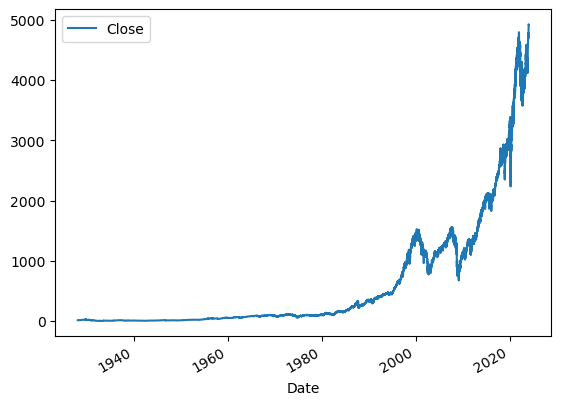